## <b>Test_Analyse e‑commerce 2023 vs 2024 — thelook_ecommerce </b>

### 1. Descriptions des variables

#### 1.1. Aperçu global du jeu de données et re-typage des données
Commençons par importer notre jeu de données sous format csv et le convertir en DataFrame.

In [1]:
import pandas as pd
import numpy as np

# Chargement du fichier csv
df = pd.read_csv("../data/thelook_fr_women_2023_2024.csv")

# Dimensions du jeu de données
print(f'Le jeu de donnée fait {df.shape[0]} lignes et {df.shape[1]} colonnes')

# En-tête du jeu de données
df.head()

Le jeu de donnée fait 1679 lignes et 20 colonnes


,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
0,19425,28112,6983,2023-01-01 06:18:03+00:00,Shipped,29.500000,16.048000,Shorts,Women,Fox,Fox Juniors Momentum Short,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,15644,F,France,Centre-Val de Loire,Corquilleroy
1,19425,28113,10597,2023-01-01 06:44:58+00:00,Shipped,20.000000,10.000000,Intimates,Women,Wacoal,Wacoal Women's B-Smooth Bralette,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,15644,F,France,Centre-Val de Loire,Corquilleroy
2,4710,6730,11792,2023-01-03 04:44:50+00:00,Complete,38.000000,18.468000,Intimates,Women,American Apparel,American Apparel Striped Chiffon Tank,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris
3,16618,24006,329,2023-01-03 15:13:39+00:00,Complete,27.990000,16.402140,Tops & Tees,Women,Tri-Mountain,Tri-Mountain Women's 3/4-Sleeve Pique Knit Pol...,Complete,2023-01-03 18:58:00+00:00,2023-01-05 13:23:00+00:00,2023-01-09 10:25:00+00:00,13422,F,France,Hauts-de-France,Comines
4,4710,6731,5295,2023-01-05 06:43:09+00:00,Complete,56.880001,29.577601,Pants & Capris,Women,Lauren by Ralph Lauren,Lauren Ralph Lauren Velour Pants,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris


Une fois notre DataFrame créé, intéressons-nous aux colonnes grace à la méthode .info de pandas, puis nous allons créer ensuite un dictionnaire les décrivant (définition, type, exemple).

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          1679 non-null   int64  
 1   order_item_id     1679 non-null   int64  
 2   product_id        1679 non-null   int64  
 3   item_created_at   1679 non-null   object 
 4   item_status       1679 non-null   object 
 5   sale_price        1679 non-null   float64
 6   cost              1679 non-null   float64
 7   category          1679 non-null   object 
 8   department        1679 non-null   object 
 9   brand             1677 non-null   object 
 10  product_name      1679 non-null   object 
 11  order_status      1679 non-null   object 
 12  order_created_at  1679 non-null   object 
 13  shipped_at        1133 non-null   object 
 14  delivered_at      636 non-null    object 
 15  user_id           1679 non-null   int64  
 16  gender            1679 non-null   object 


On observe déjà que l'essentiel des valeurs manquantes se trouve dans les deux variables `shipped_at` et `delivered_at`, ce qui n'est pas surprenant si on considère qu'un certain nombre de commandes n'ont pas encore été expédiées et livrées au moment de l'extraction des bases.
Il existe également 2 valeurs manquantes pour la colonne brand.

On peut d'ores et déjà changer le type object en date pour les colonnes de date et en category pour les colonnes catégorielles . 

In [3]:
# Affichage des colonnes catégorielles
df.select_dtypes(include='object').head()

,item_created_at,item_status,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,gender,country,state,city
0,2023-01-01 06:18:03+00:00,Shipped,Shorts,Women,Fox,Fox Juniors Momentum Short,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,F,France,Centre-Val de Loire,Corquilleroy
1,2023-01-01 06:44:58+00:00,Shipped,Intimates,Women,Wacoal,Wacoal Women's B-Smooth Bralette,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,F,France,Centre-Val de Loire,Corquilleroy
2,2023-01-03 04:44:50+00:00,Complete,Intimates,Women,American Apparel,American Apparel Striped Chiffon Tank,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,F,France,Île-de-France,Paris
3,2023-01-03 15:13:39+00:00,Complete,Tops & Tees,Women,Tri-Mountain,Tri-Mountain Women's 3/4-Sleeve Pique Knit Pol...,Complete,2023-01-03 18:58:00+00:00,2023-01-05 13:23:00+00:00,2023-01-09 10:25:00+00:00,F,France,Hauts-de-France,Comines
4,2023-01-05 06:43:09+00:00,Complete,Pants & Capris,Women,Lauren by Ralph Lauren,Lauren Ralph Lauren Velour Pants,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,F,France,Île-de-France,Paris


Les date sont au format objet, ce qui n'est pas très pratique pour trier notre DataFrame.
Nous allons commencer par parser les dates.

In [4]:
col_dates = ["item_created_at", "order_created_at", "shipped_at", "delivered_at"]

# Formatage de la date 
for c in col_dates:
    dates = pd.to_datetime(df[c], errors='coerce')
    df[c] = dates

Maintenant que les dates sont parsées, nous allons déterminer pour quelles colonnes il faudrait typer en category.

En effet, il n'est pas souhaitable de typer en category lorsqu'il y a un nombre trop important de modalités pour une colonne donnée. Cherchons alors à connaître le nombre de modalités uniques pour chaque colonne avec la méthode nunique.

In [5]:
for col in df.select_dtypes(include='object').columns.to_list():
    print(f'Colonne {col} : {df[col].nunique()}')

Colonne item_status : 5
Colonne category : 22
Colonne department : 1
Colonne brand : 657
Colonne product_name : 1559
Colonne order_status : 5
Colonne gender : 1
Colonne country : 1
Colonne state : 13
Colonne city : 547


 Les colonnes `brand` et `product_name` ont un nombre important de modalités uniques. Ainsi, nous les laisserons en format object.

 Changeons le type des autres colonnes catégorielles :

In [6]:
# Changement des type object en category pour les variables catégorielles
cat_list = ["item_status", "category", "department", "order_status", "gender", "country", "state", "city"]
df[cat_list] = df[cat_list].astype('category')

Finalement après toutes ces opérations, il est temps de re-contrôler le type de nos données.

In [7]:
# Contrôle du type des données
df.dtypes

order_id                          int64
order_item_id                     int64
product_id                        int64
item_created_at     datetime64[ns, UTC]
item_status                    category
sale_price                      float64
cost                            float64
category                       category
department                     category
brand                            object
product_name                     object
order_status                   category
order_created_at    datetime64[ns, UTC]
shipped_at          datetime64[ns, UTC]
delivered_at        datetime64[ns, UTC]
user_id                           int64
gender                         category
country                        category
state                          category
city                           category
dtype: object

Nos données catégorielles et de dates sont à présent bien typées. On créé maintenant notre dictionnaire de données permettant de décrire les colonnes.

#### 1.2. Création du dictionnaire de données
On va maintenant procéder à la création du du dictionnaire des données.

In [8]:
# Création du dictionnaire
dict = pd.DataFrame({
    "Colonne": df.columns.to_list(),
    "Type": df.dtypes.values,
})

# Création des définitions métiers
definitions = {
    "order_id": "Identifiant unique de la commande. Une même commande peut contenir plusieurs lignes.",
    "order_item_id": "Identifiant unique de la ligne de commande (item).",
    "product_id": "Identifiant unique du produit vendu.",
    "item_created_at": "Date et heure de création de la ligne de commande.",
    "item_status": "Statut de la ligne de commande (Shipped, Cancelled, Returned…).",
    "sale_price": "Prix de vente facturé au client pour cette ligne de commande.",
    "cost": "Coût interne du produit pour l’entreprise (achat ou production).",
    "category": "Catégorie du produit (Shorts, Tops & Tees…).",
    "department": "Département / segment marché (Women).",
    "brand": "Marque du produit.",
    "product_name": "Nom commercial du produit.",
    "order_status": "Statut global de la commande (Shipped, Processing, Cancelled…).",
    "order_created_at": "Date de création de la commande.",
    "shipped_at": "Date d’expédition de la commande ou de la ligne.",
    "delivered_at": "Date de livraison au client.",
    "user_id": "Identifiant unique du client.",
    "gender": "Genre déclaré du client.",
    "country": "Pays de livraison.",
    "state": "Région / État de livraison.",
    "city": "Ville de livraison."
}

# Ajout au DataFrame
dict["definition"] = dict["Colonne"].map(definitions)

# Ajout de la colonne Exemple
dict['Exemple'] = df.apply(lambda l: l.dropna().iloc[0] if l.dropna().size > 0 else None).values
dict

,Colonne,Type,definition,Exemple
0,order_id,int64,Identifiant unique de la commande. Une même co...,19425
1,order_item_id,int64,Identifiant unique de la ligne de commande (it...,28112
2,product_id,int64,Identifiant unique du produit vendu.,6983
3,item_created_at,"datetime64[ns, UTC]",Date et heure de création de la ligne de comma...,2023-01-01 06:18:03+00:00
4,item_status,category,"Statut de la ligne de commande (Shipped, Cance...",Shipped
5,sale_price,float64,Prix de vente facturé au client pour cette lig...,29.5
6,cost,float64,Coût interne du produit pour l’entreprise (ach...,16.048
7,category,category,"Catégorie du produit (Shorts, Tops & Tees…).",Shorts
8,department,category,Département / segment marché (Women).,Women
9,brand,object,Marque du produit.,Fox


Utilisons la méthode .unique pour avoir une idée des différentes modalités des variables catégorielles.

In [9]:
# Affichage des différentes modalités uniques des colonnes catégorielles
for col in df.select_dtypes(include='category').columns.to_list():
    print(f'Colonne {col} : {df[col].unique()}')

Colonne item_status : ['Shipped', 'Complete', 'Processing', 'Returned', 'Cancelled']
Categories (5, object): ['Cancelled', 'Complete', 'Processing', 'Returned', 'Shipped']
Colonne category : ['Shorts', 'Intimates', 'Tops & Tees', 'Pants & Capris', 'Blazers & Jackets', ..., 'Socks & Hosiery', 'Leggings', 'Outerwear & Coats', 'Skirts', 'Clothing Sets']
Length: 22
Categories (22, object): ['Accessories', 'Active', 'Blazers & Jackets', 'Clothing Sets', ..., 'Suits', 'Sweaters', 'Swim', 'Tops & Tees']
Colonne department : ['Women']
Categories (1, object): ['Women']
Colonne order_status : ['Shipped', 'Complete', 'Processing', 'Returned', 'Cancelled']
Categories (5, object): ['Cancelled', 'Complete', 'Processing', 'Returned', 'Shipped']
Colonne gender : ['F']
Categories (1, object): ['F']
Colonne country : ['France']
Categories (1, object): ['France']
Colonne state : ['Centre-Val de Loire', 'Île-de-France', 'Hauts-de-France', 'Normandie', 'Occitanie', ..., 'Provence-Alpes-Côte d'Azur', 'Breta

### 2. Contrôle de qualité des données

#### 2.1. Traitement des doublons
On va chercher dans un premier temps à voir s'il existe des observations intégralement dupliquées.

In [10]:
# Recherche d'observations intégralement dupliquées 
print(f"Il y a {df.duplicated().sum()} ligne(s) intégralement dupliquée(s)")

Il y a 0 ligne(s) intégralement dupliquée(s)


On voit qu'il n'y a aucune ligne intégralement dupliquée. On pourrait maintenant chercher à avoir le nombre de modalités uniques par colonne pour savoir s'il existe des observations partiellement dupliquées sur des variables censées être uniques.

In [11]:
for col in df.columns.to_list():
    print(f'Colonne {col} : {df[col].nunique()}')

Colonne order_id : 1117
Colonne order_item_id : 1679
Colonne product_id : 1573
Colonne item_created_at : 1679
Colonne item_status : 5
Colonne sale_price : 703
Colonne cost : 1561
Colonne category : 22
Colonne department : 1
Colonne brand : 657
Colonne product_name : 1559
Colonne order_status : 5
Colonne order_created_at : 1117
Colonne shipped_at : 747
Colonne delivered_at : 416
Colonne user_id : 868
Colonne gender : 1
Colonne country : 1
Colonne state : 13
Colonne city : 547


On observe que `order_id` a des valeurs qui se répètent car il en existe 1117 uniques sur 1679 lignes avec aucune valeur manquante, ce qui est normal car le numéro de commande peut se retrouver sur plusieurs lignes liées à cette même commande. 

La variable `order_item_id` a bien 1679 modalités uniques ce qui est bon signe car ce numéro est l'identifiant unique d'une ligne de commande donnée. C'est la clé primaire du dataset.

`user_id` qui est l'identifiant unique du client, revient dans plusieurs lignes du jeu de données. Mais cela peut s'expliquer dans la mesure où un client peut se retrouver sur toutes les lignes de sa commande et peut également effectuer plusieurs commandes.

Pareil pour `shipped_at` et `delivered_at` qui sont communs à plusieurs lignes d'une même commande lorque la commande concerne plus d'un article.

La colonne `product_id` contient des doublons mais cela doit venir du fait que des produits se retrouvent dans plusieurs commandes distinctes.

A présent, nous allons effectuer des test pour corroborer nos hypothèses et essayer de débusquer des vrais faux-doublons s'il en existe.

Vérifions dans un premier temps si une ligne de commande d'un article à pu être dupliquée au sein d'une même commande : 

In [12]:
# Recherche de doublons sur le subset composé des colonnes order_id, product_id
df.duplicated(subset=["order_id", "product_id"], keep=False).sum()


np.int64(0)

La clé (`order_id`, `product_id`) étant unique dans le jeu de données, il n'y a pas de ligne contenant à un produit dupliquée au sein d'une même commande. De plus, aucun doublon ne sera observé a fortiori lorsque l’on étendra cette clé à des variables supplémentaires telles que le prix de vente ou le statut.

In [13]:
# Recherche de doublons de product_id avec mise en ordre
df[df.duplicated(subset=["product_id"], keep=False)].sort_values(by="product_id", ascending=True)

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
771,76498,111095,248,2024-01-30 10:43:28+00:00,Complete,7.900000,4.092200,Tops & Tees,Women,Tresics,Tresics Camisole With Built In Bra sc1410,Complete,2024-01-27 13:13:00+00:00,2024-01-28 02:14:00+00:00,2024-01-28 09:49:00+00:00,61245,F,France,Hauts-de-France,Lille
578,31339,45463,248,2023-11-11 04:00:06+00:00,Shipped,7.900000,4.092200,Tops & Tees,Women,Tresics,Tresics Camisole With Built In Bra sc1410,Shipped,2023-11-11 06:56:00+00:00,2023-11-13 19:36:00+00:00,NaT,25182,F,France,Auvergne-Rhône-Alpes,Lyon
585,18092,26160,319,2023-11-13 14:54:04+00:00,Shipped,27.590000,14.153670,Tops & Tees,Women,Patty,Patty Women Sexiest & Stunning Lace Back Ruche...,Shipped,2023-11-11 18:41:00+00:00,2023-11-14 02:00:00+00:00,NaT,14607,F,France,Grand Est,Illfurth
1613,107850,156620,319,2024-12-10 07:30:53+00:00,Shipped,27.590000,14.153670,Tops & Tees,Women,Patty,Patty Women Sexiest & Stunning Lace Back Ruche...,Shipped,2024-12-09 08:46:00+00:00,2024-12-11 22:57:00+00:00,NaT,86210,F,France,Auvergne-Rhône-Alpes,Arpajon-sur-Cère
1557,17381,25141,476,2024-11-24 02:11:03+00:00,Complete,39.000000,20.241000,Tops & Tees,Women,Coolibar,Coolibar UPF 50+ Women's Long Sleeve T-Shirt -...,Complete,2024-11-24 02:57:00+00:00,2024-11-26 22:24:00+00:00,2024-11-28 00:00:00+00:00,14039,F,France,Bretagne,Bain-de-Bretagne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660,124414,180676,15313,2024-12-26 14:13:00+00:00,Cancelled,9.120000,4.632960,Plus,Women,Foot Traffic,Soft and Warm Microfiber Fuzzy Socks in Your C...,Cancelled,2024-12-26 16:58:00+00:00,NaT,NaT,99420,F,France,Bourgogne-Franche-Comté,Dijon
283,99905,145110,15688,2023-06-07 04:59:43+00:00,Cancelled,35.000000,15.890000,Plus,Women,Olga,Olga Women's Signature Support Bra,Cancelled,2023-06-06 06:45:00+00:00,NaT,NaT,79825,F,France,Nouvelle-Aquitaine,Lons
989,26750,38799,15688,2024-05-14 08:04:07+00:00,Complete,35.000000,15.890000,Plus,Women,Olga,Olga Women's Signature Support Bra,Complete,2024-05-10 09:08:00+00:00,2024-05-12 04:45:00+00:00,2024-05-13 22:33:00+00:00,21516,F,France,Pays de la Loire,Saint-Sébastien-sur-Loire
387,28985,42048,15945,2023-08-08 15:32:40+00:00,Cancelled,89.989998,46.794799,Plus,Women,Oakley,Oakley Men's Square Wire Iridium Sunglasses,Cancelled,2023-08-08 16:14:00+00:00,NaT,NaT,23276,F,France,Auvergne-Rhône-Alpes,Mercury


On observe bien que des produits ont été commandés dans des commandes distinctes. Pour avoir une meilleure idée du nombre de commandes par produit, utilisons value_count.

In [14]:
# Répartion du nombre de commandes par produit
df["product_id"].value_counts()[df["product_id"].value_counts() > 1]

product_id
9567     3
14288    3
8146     3
7729     2
5295     2
        ..
7536     2
5559     2
12437    2
13963    2
15313    2
Name: count, Length: 103, dtype: int64

Il existe trois produits au total qui ont été commandé trois fois et le reste deux fois.

Il serait également intéressant de savoir si un même identifiant produit peut avoir plusieurs noms et s'il peut se retrouver dans plusieurs catégories.

In [15]:
# Relation entre identifiant produit et nom du produit
df.groupby("product_id")["product_name"].nunique().sort_values(ascending=False)


product_id
12       1
13       1
18       1
23       1
34       1
        ..
15967    1
15971    1
15977    1
15979    1
15982    1
Name: product_name, Length: 1573, dtype: int64

On voit que pour un identifiant produit nommé il ne lui est associé qu'un seul nom de produit. En revanche, un nom produit peut être commun à plusieurs identifiant produit car il y en a moins que les product_id.

In [16]:
# Relation entre identifiant produit et la catégorie
df.groupby("product_id")["category"].nunique().sort_values(ascending=False)


product_id
12       1
13       1
18       1
23       1
34       1
        ..
15967    1
15971    1
15977    1
15979    1
15982    1
Name: category, Length: 1573, dtype: int64

On voit que pour un identifiant produit nommé il ne lui est associé qu'une seule catégorie.
Enfin il serait intéressant d'observer le nombre de commandes par identifiant unique de client :

In [17]:
df.groupby("user_id")["order_id"].nunique().sort_values(ascending=False)


user_id
25004    4
36315    4
70080    4
91268    4
3055     3
        ..
99420    1
99513    1
99618    1
99686    1
555      1
Name: order_id, Length: 868, dtype: int64

Les vérifications effectuées sur des clés métier composites (`order_id`, `product_id`) ne révèlent aucun doublon, confirmant qu’un même produit n’apparaît jamais plusieurs fois au sein d’une même commande.

Par ailleurs, le référentiel produit est cohérent : chaque product_id est associé à un unique nom de produit et à une seule catégorie, sans variation observée.

Ces résultats confirment la qualité structurelle du jeu de données et permettent de poursuivre l’analyse sans opération de déduplication.

#### 2.2. Traitement des valeurs manquantes
On va maintenant chercher à savoir s'il existe des valeurs manquantes et comment les traiter. On a vu que pour certains champs comme `shipped_at` et `delivered_at`, il était normal d'avoir des valeurs manquantes, il sera préférable de les laisser simplement en NaT. 

On en observe en revanche deux dans le champ `brand`. Cherchons alors la meilleure méthode d'imputation pour ces deux observations. 

In [18]:
# Affichage des observations où on a pas d'information concernant la variable brand
df[df["brand"].isna()]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,NaN,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,NaN,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Une première stratégie d'imputation serait de chercher si ces produits se retrouvent ailleurs dans le DataFrame et leur imputer la valeur de brand d'un hypothétique même produit.

In [19]:
# Identification des product_id dont la marque est manquante
missing_brand_products = df.loc[df["brand"].isna(), "product_id"].unique()

# Vérification de s'ils apparaissent ailleurs dans le dataset
df[df["product_id"].isin(missing_brand_products)] \
  .sort_values("product_id")


,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,NaN,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,NaN,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Ces produits sont uniques, on ne peut donc pas imputer avec la valeur de brand hypothétique. On va donc se contenter de remplacer par *"missing"*.

In [20]:
# Imputation par missing
df.fillna({"brand": "missing"}, inplace=True)

# Affichage des observations où on a pas d'information concernant la variable brand
df[df["brand"]=="missing"]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,missing,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,missing,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Les valeurs manquantes sont à présent traitées, passont maintenant à la vérification des bornes temporelles en regard du sous-périmètre métier.

#### 2.3. Cohérence des bornes temporelles


Les dates sont maintenant au bon format. On voit cependant qu'il existe des outliers car certaines bornes temporelles sont avant 2023 et certaines après 2024.
Cherchons à savoir combien de dates sont concernées.

In [21]:
col_dates = ["item_created_at", "order_created_at", "shipped_at", "delivered_at"]
for co in col_dates:
    print(f"La date la plus ancienne de {co} est : {df[co].min()} \nLa date la plus récente de {co} est : {df[co].max()}\n")
    print(f"Colonne {co} : {(df[co] < '2023-01-01 00:00:00+00:00').sum()} dates antérieures à 2023 et {(df[co] > '2025-01-01 00:00:00+00:00').sum()} postérieures à 2024\n")
    

La date la plus ancienne de item_created_at est : 2023-01-01 06:18:03+00:00 
La date la plus récente de item_created_at est : 2024-12-31 10:40:48+00:00

Colonne item_created_at : 0 dates antérieures à 2023 et 0 postérieures à 2024

La date la plus ancienne de order_created_at est : 2022-12-29 10:00:00+00:00 
La date la plus récente de order_created_at est : 2024-12-31 05:13:00+00:00

Colonne order_created_at : 2 dates antérieures à 2023 et 0 postérieures à 2024

La date la plus ancienne de shipped_at est : 2022-12-30 11:29:00+00:00 
La date la plus récente de shipped_at est : 2025-01-02 02:26:00+00:00

Colonne shipped_at : 2 dates antérieures à 2023 et 2 postérieures à 2024

La date la plus ancienne de delivered_at est : 2023-01-04 03:03:00+00:00 
La date la plus récente de delivered_at est : 2025-01-02 13:06:00+00:00

Colonne delivered_at : 0 dates antérieures à 2023 et 2 postérieures à 2024



On voit que 2 commandes ont été créées fin 2022 (order_created_at ) et que 2 autres ont été expédiées et livrées après 2024. on va se baser sur la date de création de la commande et donc supprimer les observations dont la commande a été passée avant 2023.

In [22]:
# Suppression des observations dont la commande a été passée avant 2023
df.drop(
    df[df["order_created_at"] < "2023-01-01"].index,
    inplace=True
)


In [23]:
col = ["item_created_at", "order_created_at", "shipped_at", "delivered_at"]
for co in col:
    print(f"La date la plus ancienne de {co} est : {df[co].min()} \nLa date la plus récente de {co} est : {df[co].max()}\n")
    print(f"Colonne {co} : {(df[co] < '2023-01-01 00:00:00+00:00').sum()} dates antérieures à 2023 et {(df[co] > '2025-01-01 00:00:00+00:00').sum()} postérieures à 2024\n")

La date la plus ancienne de item_created_at est : 2023-01-03 04:44:50+00:00 
La date la plus récente de item_created_at est : 2024-12-31 10:40:48+00:00

Colonne item_created_at : 0 dates antérieures à 2023 et 0 postérieures à 2024

La date la plus ancienne de order_created_at est : 2023-01-03 08:12:00+00:00 
La date la plus récente de order_created_at est : 2024-12-31 05:13:00+00:00

Colonne order_created_at : 0 dates antérieures à 2023 et 0 postérieures à 2024

La date la plus ancienne de shipped_at est : 2023-01-03 09:14:00+00:00 
La date la plus récente de shipped_at est : 2025-01-02 02:26:00+00:00

Colonne shipped_at : 0 dates antérieures à 2023 et 2 postérieures à 2024

La date la plus ancienne de delivered_at est : 2023-01-04 03:03:00+00:00 
La date la plus récente de delivered_at est : 2025-01-02 13:06:00+00:00

Colonne delivered_at : 0 dates antérieures à 2023 et 2 postérieures à 2024



In [24]:
# Dimensions du jeu de données
print(f'Le jeu de donnée fait {df.shape[0]} lignes et {df.shape[1]} colonnes')

Le jeu de donnée fait 1677 lignes et 20 colonnes


Nous avons désormais mis en forme et nettoyé nos données. Nous avons également redéfini nos bornes temporelles pour correspondre à la demande Métier. Il est temps à présent de se lancer dans l'exploration descriptive.

### 3. Explorations descriptives

#### 3.1. Distribution des données de prix de vente et de coût
Commençons tout d'abord par avoir une idée de la distribution des données liées aux prix de vente et au coût des produits. Utilisons pour cela la méthode describe().

In [25]:
df[["sale_price", "cost"]].describe()

,sale_price,cost
count,1677.000000,1677.000000
mean,57.060256,27.477283
std,69.714693,31.869373
min,1.820000,0.749840
25%,19.990000,9.666000
50%,38.000000,18.240000
75%,68.000000,33.275839
max,903.000000,437.052001


On peut déjà remarquer que les distributions des données de prix de vente et de coût ont le même profil, leur moyenne est supérieure à leur médiane et leur écart-type est supérieur à la moyenne, ce qui signifie un certain nombre de valeurs élévées.

Visualisons nos données avec des boxplot de manière à mieux visualiser les distributions.

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_22684\1313833160.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


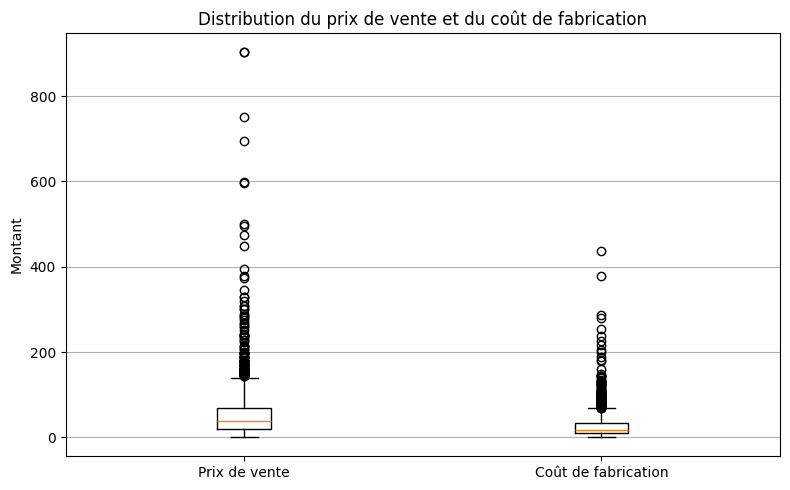

In [26]:
import matplotlib.pyplot as plt

data = [
    df["sale_price"],
    df["cost"]
]

plt.figure(figsize=(8, 5))
plt.boxplot(
    data,
    labels=["Prix de vente", "Coût de fabrication"],
)

plt.title("Distribution du prix de vente et du coût de fabrication")
plt.ylabel("Montant")
plt.tight_layout()
plt.grid(axis="y")
plt.show()


On note ici la présence importante d'outliers. Ces outliers sont des valeurs normales d'un point de vue métier, il n'est donc pas question de supprimer ces observations. Cependant ils écrasent les boxplots et ne permettent pas une visualisation optimale de nos données.
On pourrait alors par exemple n'afficher que les 99 premiers percentiles de manière à 'zoomer' sur les valeurs plus centrales.

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_22684\3035780615.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Prix de vente", "Coût de fabrication"])


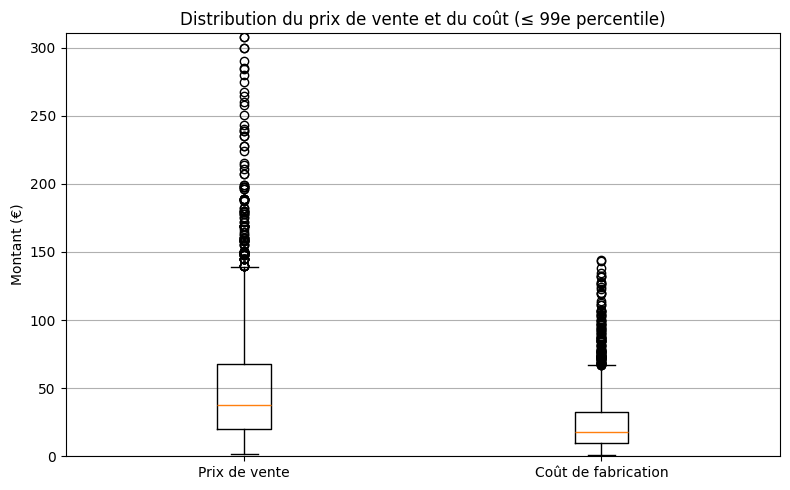

In [27]:
# Calcul des seuils 99%
q99_sale = df["sale_price"].quantile(0.99)
q99_cost = df["cost"].quantile(0.99)

# Filtrage
data = [
    df.loc[df["sale_price"] <= q99_sale, "sale_price"],
    df.loc[df["cost"] <= q99_cost, "cost"]
]

# Échelle commune
y_max = max(q99_sale, q99_cost)

# Figure unique avec deux boxplots
plt.figure(figsize=(8, 5))
plt.boxplot(data, labels=["Prix de vente", "Coût de fabrication"])
plt.ylim(0, y_max)
plt.ylabel("Montant (€)")
plt.title("Distribution du prix de vente et du coût (≤ 99e percentile)")

plt.tight_layout()
plt.grid(axis="y")
plt.show()


Les visualisations sont moins écrasées et plus lisibles.

Nous pouvons également représenter nos données avec un histogramme et la librairie seaborn.

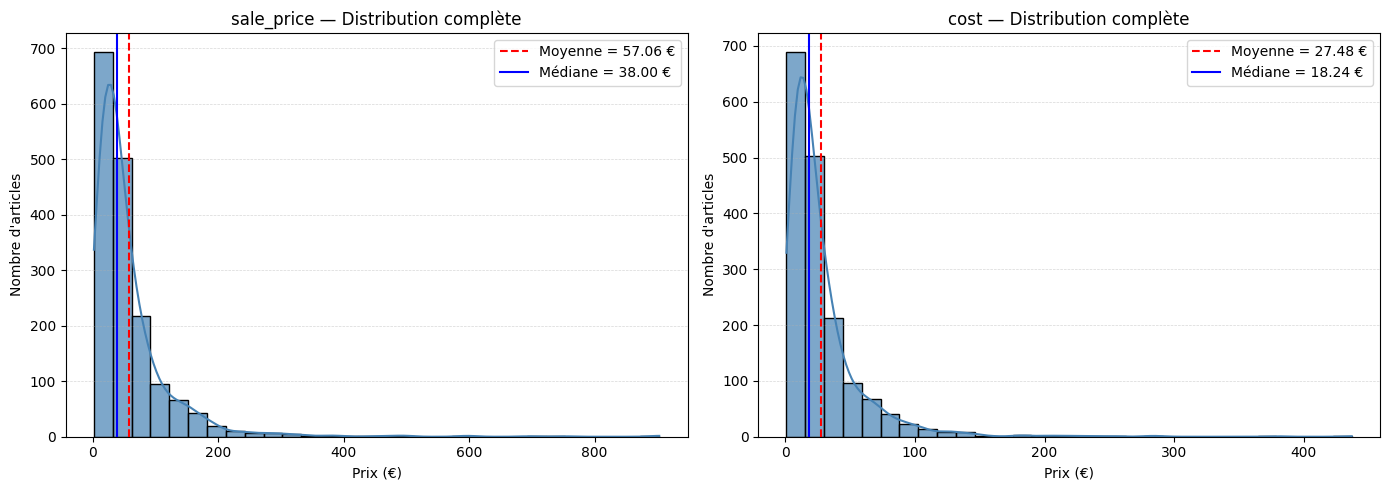

In [28]:
import seaborn as sns

# Colonnes
colonnes = ["sale_price", "cost"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, colonnes):
    x = df[col]

    # Statistiques
    mean = x.mean()
    median = x.median()

    # Histogramme
    sns.histplot(
        x,
        bins=30,
        edgecolor="black",
        alpha=0.7,
        kde=True,
        color="steelblue",
        ax=ax
    )

    # Lignes moyenne et médiane
    ax.axvline(mean, linestyle="--", color="red", label=f"Moyenne = {mean:.2f} €")
    ax.axvline(median, linestyle="-", color="blue", label=f"Médiane = {median:.2f} €")

    # Grille
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    # Titres et labels
    ax.set_title(f"{col} — Distribution complète")
    ax.set_xlabel("Prix (€)")
    ax.set_ylabel("Nombre d'articles")
    ax.legend()

plt.tight_layout()
plt.show()


Les histogrammes confirment que les données de prix de ventes et de coûts ont une structure similaire mais centrée sur une médiane plus grande pour les données de prix de ventes, ce qui est normal et correspond à la marge brute. 
On note bien une longue traîne à droite qui témoigne d'un certain nombre de valeurs extrêmes. De même, il serait opportun de n'afficher que les 99 premiers percentiles pour des raisons de visualisation. Cette représentation tronquée du dernier percentile permettra de mieux visualiser les valeurs de prix et de coût "normales" recentrées autour de la médiane.

Une autre approche intéressante serait d'utiliser une échelle logarithmique et non linéaire pour mieux visualiser les valeurs plus centrées sur la médiane. Nous pouvons résumer ces graphes sur une seule et même figure pour plus de concision.


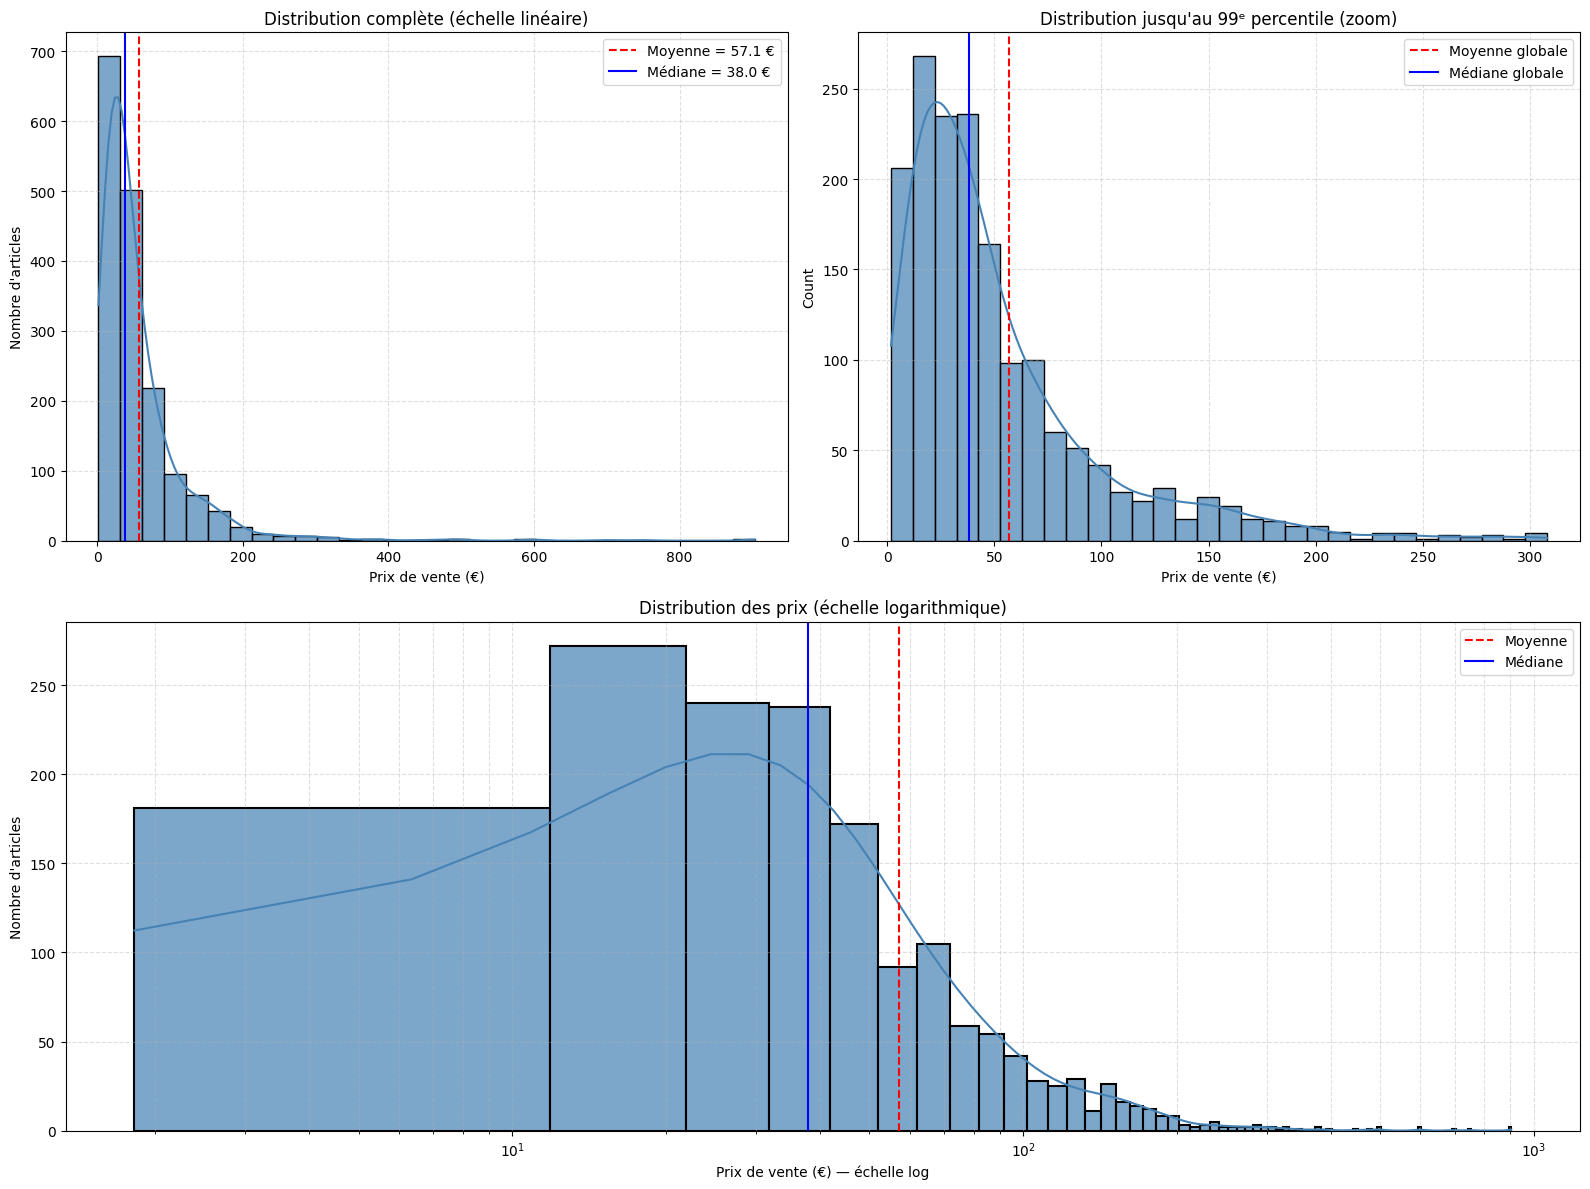

In [ ]:
# Données
x = df["sale_price"]

mean = x.mean()
median = x.median()
q99 = x.quantile(0.99)


# Figure
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2)


# 1. Distribution complète (linéaire)
ax1 = fig.add_subplot(gs[0, 0])

sns.histplot(
    x,
    bins=30,
    kde=True,
    color="steelblue",
    ax=ax1,
    alpha=0.7,
    edgecolor="black"
)

ax1.axvline(mean, color="red", linestyle="--", label=f"Moyenne = {mean:.1f} €")
ax1.axvline(median, color="blue", linestyle="-", label=f"Médiane = {median:.1f} €")
ax1.set_title("Distribution complète (échelle linéaire)")
ax1.set_xlabel("Prix de vente (€)")
ax1.set_ylabel("Nombre d'articles")
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.4)


# 2. Distribution zoomée (≤ 99e percentile)
ax2 = fig.add_subplot(gs[0, 1])

sns.histplot(
    x[x <= q99],
    bins=30,
    kde=True,
    color="steelblue",
    ax=ax2,
    alpha=0.7,
    edgecolor="black"
)

ax2.axvline(mean, color="red", linestyle="--", label="Moyenne globale")
ax2.axvline(median, color="blue", linestyle="-", label="Médiane globale")
ax2.set_title("Distribution jusqu'au 99ᵉ percentile (zoom)")
ax2.set_xlabel("Prix de vente (€)")
ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.4)


# 3. Distribution en échelle logarithmique
ax3 = fig.add_subplot(gs[1, :])

sns.histplot(
    x,
    bins=90,
    kde=True,
    color="steelblue",
    ax=ax3,
    alpha=0.7,
    edgecolor="black",
    linewidth=1.5
)

ax3.set_xscale("log")
ax3.axvline(mean, color="red", linestyle="--", label="Moyenne")
ax3.axvline(median, color="blue", linestyle="-", label="Médiane")
ax3.set_title("Distribution des prix (échelle logarithmique)")
ax3.set_xlabel("Prix de vente (€) — échelle log")
ax3.set_ylabel("Nombre d'articles")
ax3.legend()
ax3.grid(True, which="both", linestyle="--", alpha=0.4)


plt.tight_layout()
plt.show()

Même chose pour le coût :

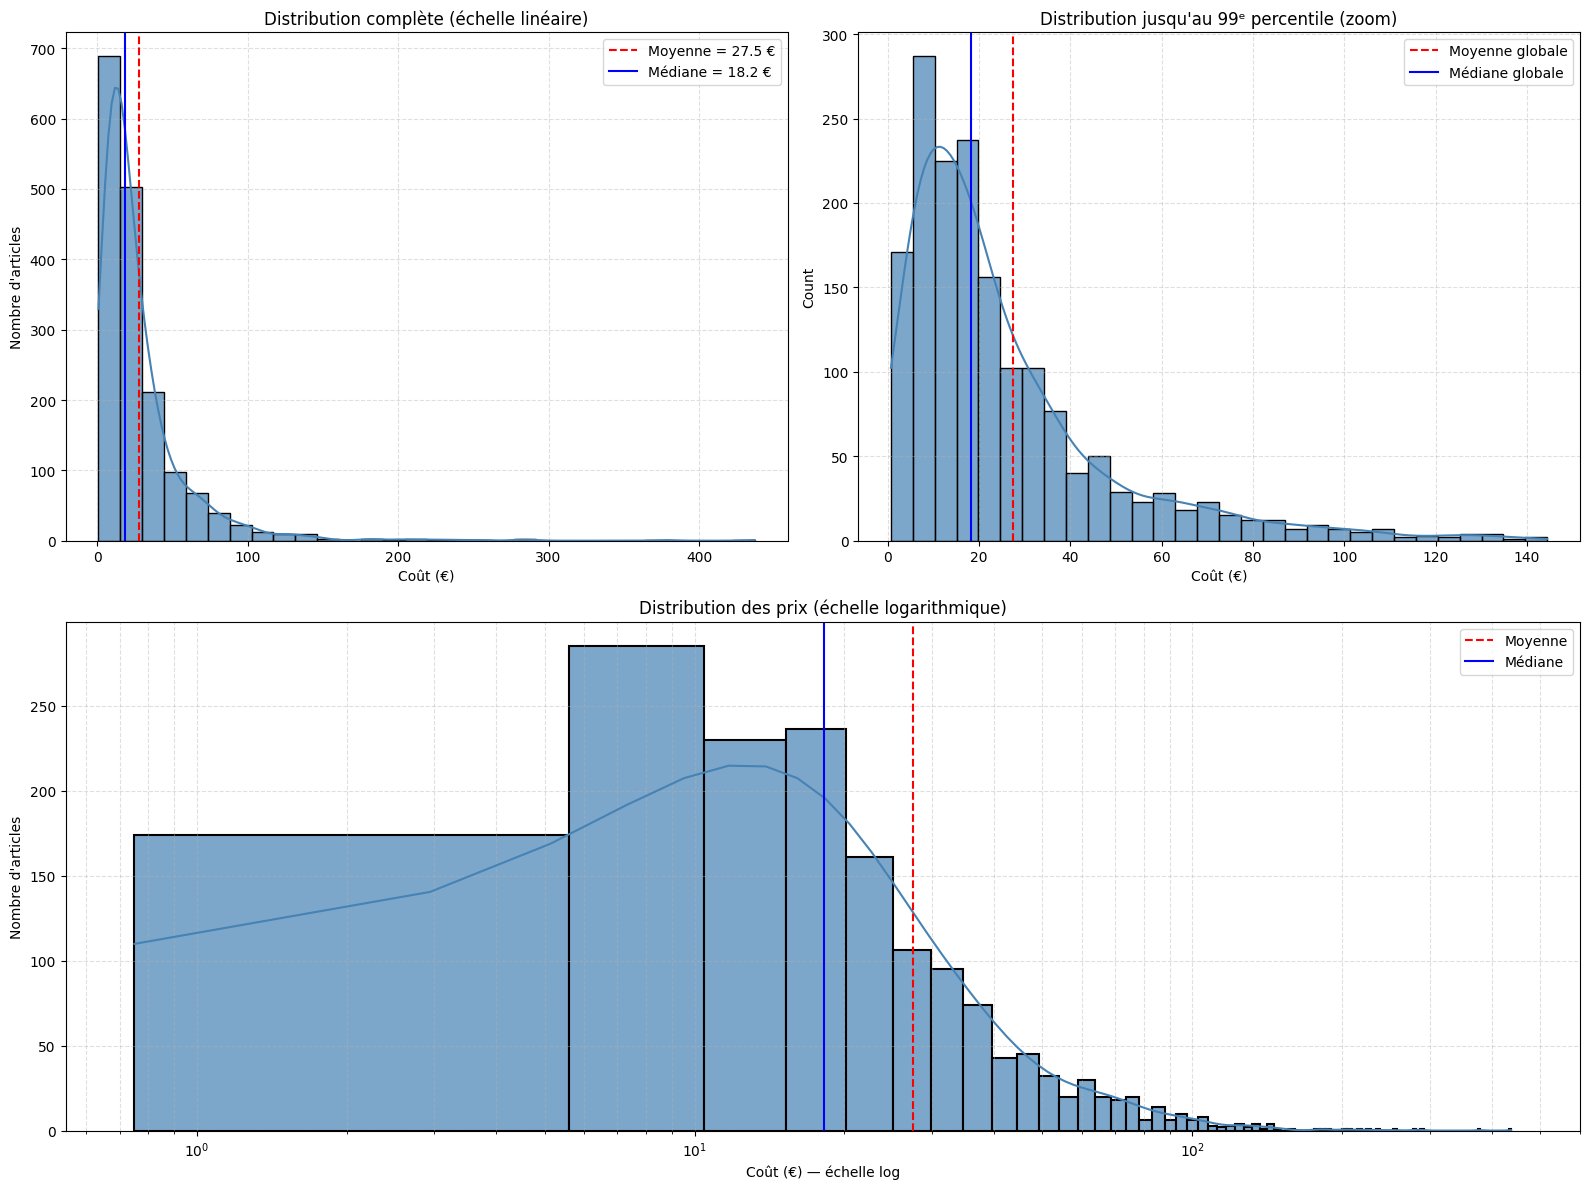

In [ ]:
# Données
x = df["cost"]

mean = x.mean()
median = x.median()
q99 = x.quantile(0.99)


# Figure
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2)


# 1. Distribution complète (linéaire)
ax1 = fig.add_subplot(gs[0, 0])

sns.histplot(
    x,
    bins=30,
    kde=True,
    color="steelblue",
    ax=ax1,
    alpha=0.7,
    edgecolor="black"
)

ax1.axvline(mean, color="red", linestyle="--", label=f"Moyenne = {mean:.1f} €")
ax1.axvline(median, color="blue", linestyle="-", label=f"Médiane = {median:.1f} €")
ax1.set_title("Distribution complète (échelle linéaire)")
ax1.set_xlabel("Coût (€)")
ax1.set_ylabel("Nombre d'articles")
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.4)


# 2. Distribution zoomée (≤ 99e percentile)
ax2 = fig.add_subplot(gs[0, 1])

sns.histplot(
    x[x <= q99],
    bins=30,
    kde=True,
    color="steelblue",
    ax=ax2,
    alpha=0.7,
    edgecolor="black"
)

ax2.axvline(mean, color="red", linestyle="--", label="Moyenne globale")
ax2.axvline(median, color="blue", linestyle="-", label="Médiane globale")
ax2.set_title("Distribution jusqu'au 99ᵉ percentile (zoom)")
ax2.set_xlabel("Coût (€)")
ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.4)


# 3. Distribution en échelle logarithmique
ax3 = fig.add_subplot(gs[1, :])

sns.histplot(
    x,
    bins=90,
    kde=True,
    color="steelblue",
    ax=ax3,
    alpha=0.7,
    edgecolor="black",
    linewidth=1.5
)

ax3.set_xscale("log")
ax3.axvline(mean, color="red", linestyle="--", label="Moyenne")
ax3.axvline(median, color="blue", linestyle="-", label="Médiane")
ax3.set_title("Distribution des prix (échelle logarithmique)")
ax3.set_xlabel("Coût (€) — échelle log")
ax3.set_ylabel("Nombre d'articles")
ax3.legend()
ax3.grid(True, which="both", linestyle="--", alpha=0.4)


# Finalisation
plt.tight_layout()
plt.show()


A la lecture des histogrammes, on constate que les distributions du prix de vente et du coût de fabrication présentent une forte asymétrie à droite, caractérisée par des moyennes supérieures aux médianes. La majorité des articles se situe dans des gammes de prix modérées, tandis qu’un nombre limité de produits à prix élevé génère une dispersion importante et des valeurs extrêmes. Cette structure est cohérente avec un catalogue e-commerce multi-gammes incluant des produits à forte valeur commerciale.

#### 3.2. Distribution des données de prix de vente et de coût par catégorie
Regardons à présent sur quelles catégories on a le plus de dispersion des prix de ventes et des coûts internes.

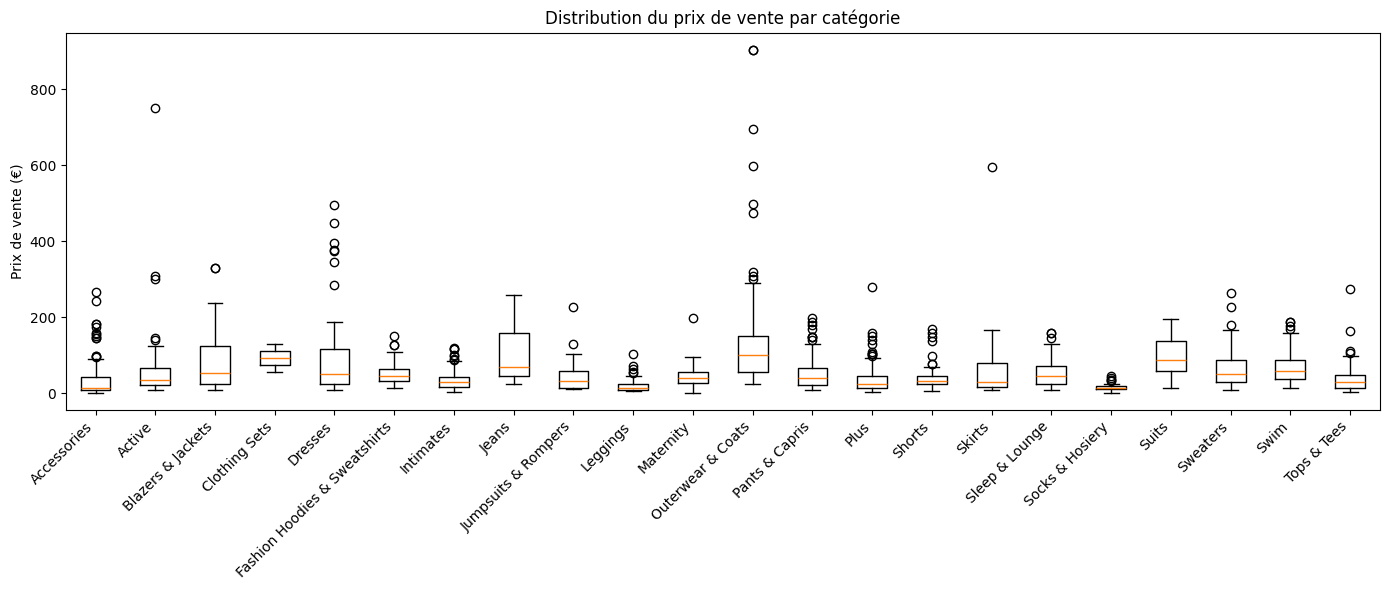

In [31]:
categories = df["category"].cat.categories
sale_data = [df.loc[df["category"] == c, "sale_price"] for c in categories]

plt.figure(figsize=(14, 6))

plt.boxplot(
    sale_data,
    widths=0.5,
)

plt.xticks(range(1, len(categories) + 1), categories, rotation=45, ha="right")
plt.ylabel("Prix de vente (€)")
plt.title("Distribution du prix de vente par catégorie")

plt.tight_layout()
plt.show()



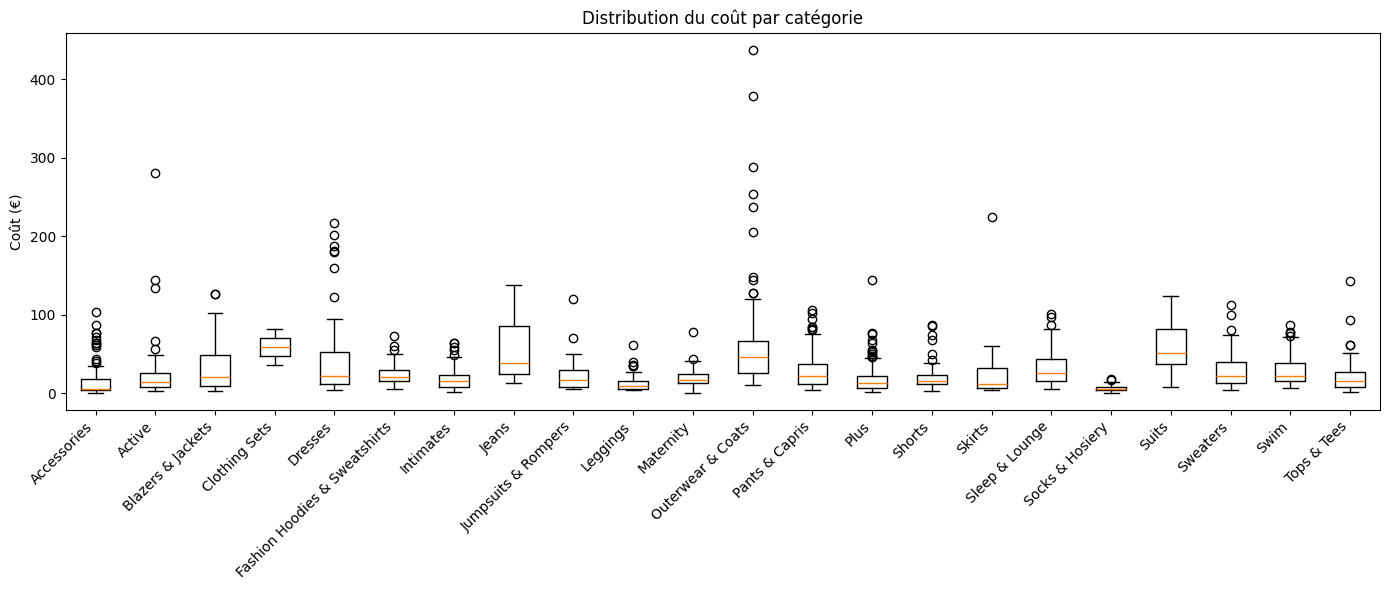

In [32]:
cost_data = [df.loc[df["category"] == c, "cost"] for c in categories]

plt.figure(figsize=(14, 6))

plt.boxplot(
    cost_data,
    widths=0.5,
)

plt.xticks(range(1, len(categories) + 1), categories, rotation=45, ha="right")
plt.ylabel("Coût (€)")
plt.title("Distribution du coût par catégorie")

plt.tight_layout()
plt.show()


On remarque ici que les dispersion des prix de vente et de coûts par catégorie ne sont pas homogènes. En effet, certaines catégorie comme Outwear & Coats, Dresses, Active ou Skirts ont des valeurs très dispersées avec des outliers élevés, tandis que certaines catégories comme Jeans, Suits et Clothing Sets ont des valeurs de prix et de coût plus resserrées.

#### 3.2. Contribution par marque, catégorie, ville, saisonnalité mensuelle 
Maintenant nous allons nous intéresser à la contribution au chiffre d'affaire global sur 2023-2024 des marques, catégories, zones géographiques et selon le mois de l'année.

Tout d'abord, quelques remarques générales sur la contribution au chiffre d'affaire des articles en fonction du prix de vente :


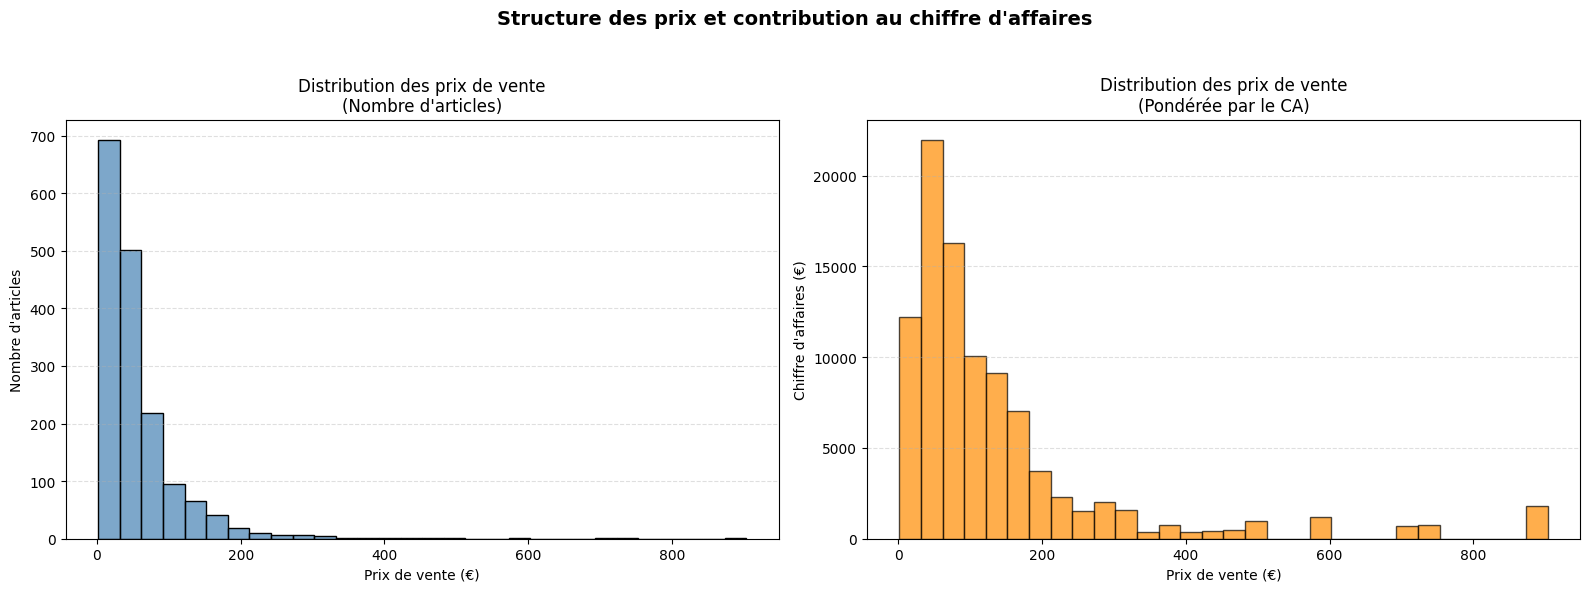

In [ ]:
# Données
prices = df["sale_price"]
weights = df["sale_price"]

# Bins communs pour comparabilité
bins = np.histogram_bin_edges(prices, bins=30)


# Création de la figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


# Subplot 1 — Fréquence
sns.histplot(
    prices,
    bins=bins,
    color="steelblue",
    edgecolor="black",
    alpha=0.7,
    ax=axes[0]
)

axes[0].set_title("Distribution des prix de vente\n(Nombre d'articles)")
axes[0].set_xlabel("Prix de vente (€)")
axes[0].set_ylabel("Nombre d'articles")
axes[0].grid(axis="y", linestyle="--", alpha=0.4)


# Subplot 2 — CA pondéré
axes[1].hist(
    prices,
    bins=bins,
    weights=weights,
    color="darkorange",
    edgecolor="black",
    alpha=0.7
)

axes[1].set_title("Distribution des prix de vente\n(Pondérée par le CA)")
axes[1].set_xlabel("Prix de vente (€)")
axes[1].set_ylabel("Chiffre d'affaires (€)")
axes[1].grid(axis="y", linestyle="--", alpha=0.4)


# Mise en forme finale
plt.suptitle(
    "Structure des prix et contribution au chiffre d'affaires",
    fontsize=14,
    fontweight="bold"
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Si on reprend notre distribution du nombre d'articles par prix de ventes et qu'on lui accole la distribution des fractions du CA en fonction du prix de vente, on note que ce ne sont pas les articles les moins chers -qui sont pourtant majoritaires en nombre- qui contribuent le plus au CA global. En effet, on voit que les articles rapportant le plus d'argent sont des articles un peu plus chers et plus rares. 

Pour nous en convaincre, traçons le CA cumulé en % du CA total avec les prix de ventes croissants :

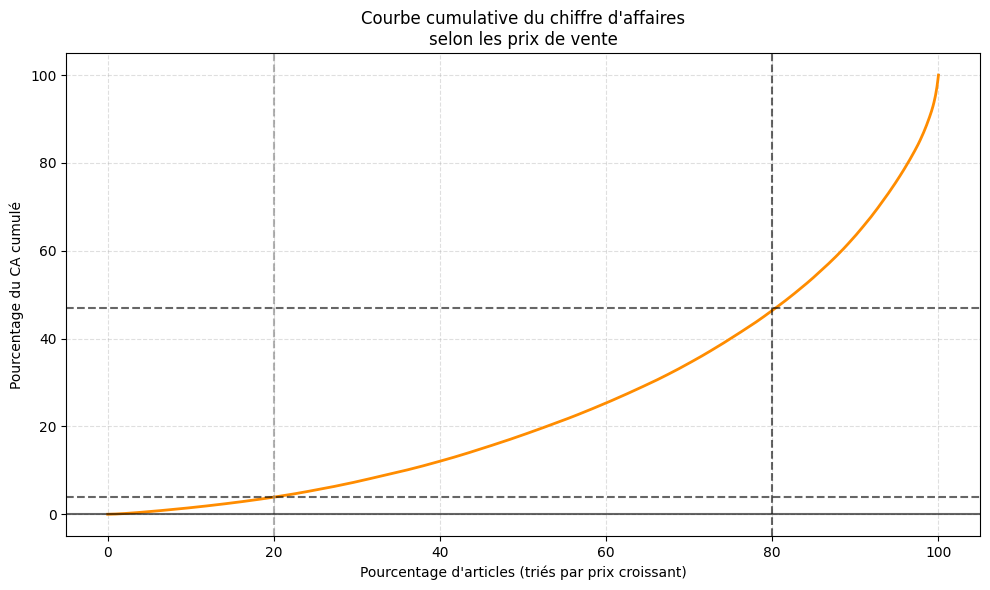

In [ ]:
# Préparation des données
df_price = (
    df[["sale_price"]]
    .sort_values("sale_price")
    .reset_index(drop=True)
)

# CA cumulé
df_price["ca_cumule"] = df_price["sale_price"].cumsum()
total_ca = df_price["sale_price"].sum()

# CA cumulé en %
df_price["ca_cumule_pct"] = df_price["ca_cumule"] / total_ca * 100

# Axe X : pourcentage d'articles
df_price["pct_articles"] = np.linspace(
    0, 100, len(df_price)
)


# Création du graphique
plt.figure(figsize=(10, 6))

plt.plot(
    df_price["pct_articles"],
    df_price["ca_cumule_pct"],
    color="darkorange",
    linewidth=2
)

# Lignes de repère
plt.axhline(47, linestyle="--", color="black", alpha=0.6)
plt.axvline(20, linestyle="--", color="grey", alpha=0.6)
plt.axvline(80, linestyle="--", color="black", alpha=0.6)
plt.axhline(4, linestyle="--", color="black", alpha=0.6)
plt.axhline(0, linestyle="-", color="black", alpha=0.6)

#plt.text(22, 82, "80 % du CA", color="grey")
#plt.text(2, 5, "20 % des articles", color="grey")

# Mise en forme
plt.title("Courbe cumulative du chiffre d'affaires\nselon les prix de vente")
plt.xlabel("Pourcentage d'articles (triés par prix croissant)")
plt.ylabel("Pourcentage du CA cumulé")
plt.grid(True, linestyle="--", alpha=0.4)


plt.tight_layout()
plt.show()

L’analyse de la courbe cumulative montre que les 20 % des articles les plus chers concentrent environ 50 % du chiffre d’affaires total, tandis que les 20% les moins chers contribuent à moins de 5% du CA total.

Cette forte concentration du CA confirme une structure de type long tail, où une minorité d’articles à prix élevés joue un rôle déterminant dans la performance globale.

Faisons maintenant une étude des marques, catégorie, villes et mois qui concentrent le plus de CA total sur 2023-2024.

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_22684\1869500162.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ville_contrib = df.groupby("city")["sale_price"].sum().sort_values(ascending=False)


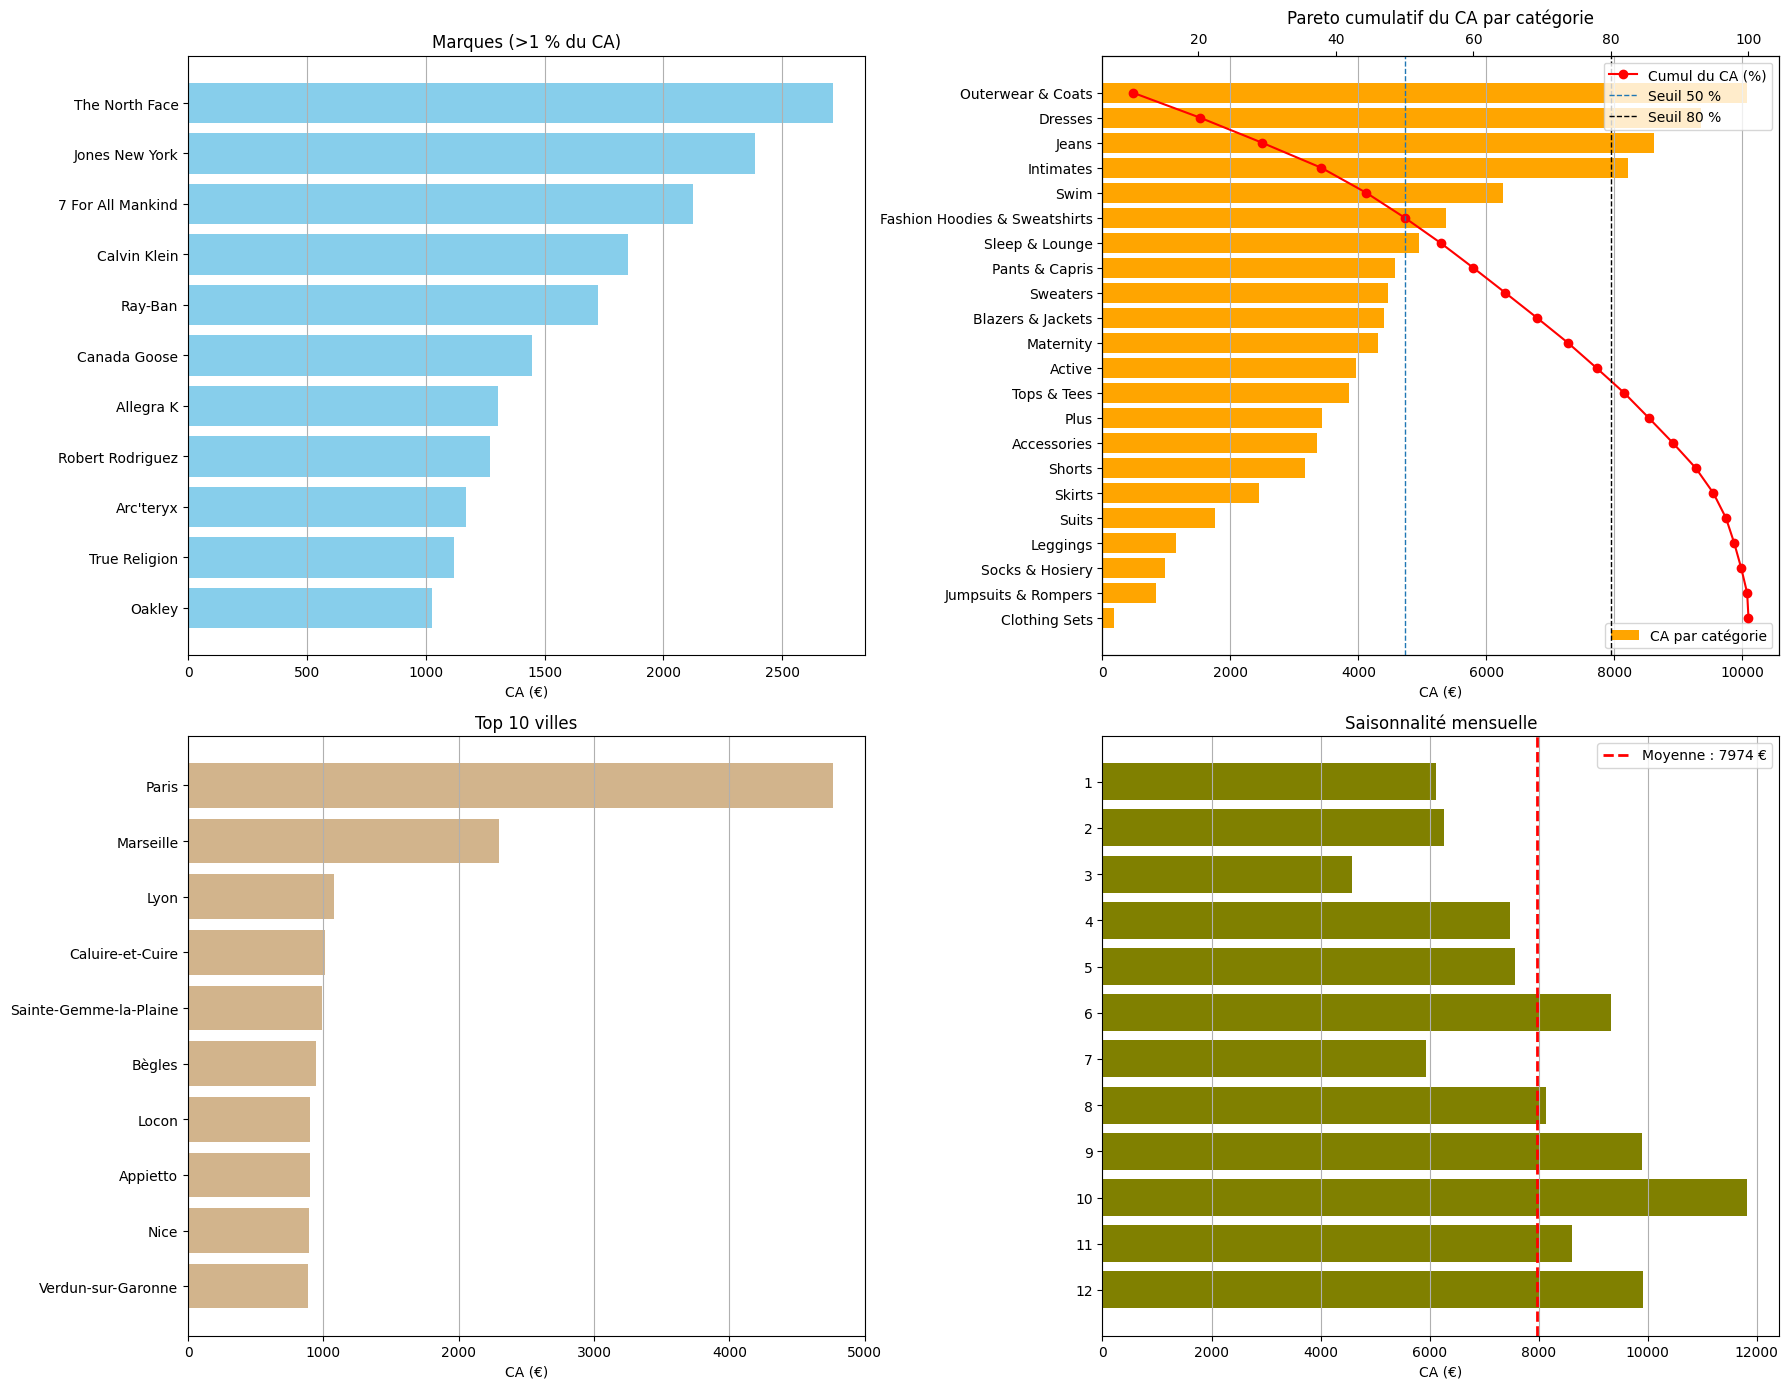

In [ ]:
# Données

# Total CA
total_ventes = df["sale_price"].sum()

# Marques (>1 % du CA)
marque_contrib = df.groupby("brand")["sale_price"].sum().sort_values(ascending=False)
marque_top = marque_contrib[marque_contrib / total_ventes > 0.01]

# Catégories (Pareto)
categorie_contrib = df.groupby("category", observed=True)["sale_price"].sum().sort_values(ascending=False)
categorie_df = categorie_contrib.reset_index()
categorie_df["cumul_pct"] = categorie_df["sale_price"].cumsum() / total_ventes * 100  # cumul en %

# Villes (top 10)
ville_contrib = df.groupby("city")["sale_price"].sum().sort_values(ascending=False)
ville_top = ville_contrib.head(10)

# Saisonnalité mensuelle
df["month"] = df["order_created_at"].dt.month
month_contrib = df.groupby("month")["sale_price"].sum().sort_index()
moyenne_mensuelle = month_contrib.mean()


# Création des subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Marques (>1 %)
axes[0, 0].barh(marque_top.index, marque_top.values, color="skyblue")
axes[0, 0].invert_yaxis()
axes[0, 0].set_title("Marques (>1 % du CA)")
axes[0, 0].set_xlabel("CA (€)")
axes[0, 0].grid(visible=True, which='major', axis='x')

# Catégories : Pareto horizontal
ax_bar = axes[0, 1]
ax_line = ax_bar.twiny()
ax_bar.grid(visible=True, which='major', axis='x')

# Barres en €
ax_bar.barh(categorie_df["category"], categorie_df["sale_price"], color="orange", label="CA par catégorie")

# Ligne cumulative en %
ax_line.plot(categorie_df["cumul_pct"], categorie_df["category"], marker="o", color="red", label="Cumul du CA (%)")

# Lignes seuils 50 % et 80 %
ax_line.axvline(50, linestyle="--", linewidth=1, label="Seuil 50 %")
ax_line.axvline(80, linestyle="--", linewidth=1, label="Seuil 80 %", color="black")

ax_bar.invert_yaxis()
ax_bar.set_title("Pareto cumulatif du CA par catégorie")
ax_bar.set_xlabel("CA (€)")

ax_bar.legend(loc="lower right")
ax_line.legend(loc="upper right")

# Villes (top 10)
axes[1, 0].barh(ville_top.index, ville_top.values, color="tan")
axes[1, 0].invert_yaxis()
axes[1, 0].grid(visible=True, which='major', axis='x')
axes[1, 0].set_title("Top 10 villes")
axes[1, 0].set_xlabel("CA (€)")

# Saisonnalité mensuelle
axes[1, 1].barh(month_contrib.index.astype(str), month_contrib.values, color="olive")
axes[1, 1].invert_yaxis()
axes[1, 1].set_title("Saisonnalité mensuelle")
axes[1, 1].set_xlabel("CA (€)")

# Ligne de moyenne mensuelle
axes[1, 1].axvline(moyenne_mensuelle, color="red", linestyle="--", linewidth=2, 
                   label=f"Moyenne : {int(round(moyenne_mensuelle))} €")
axes[1, 1].grid(visible=True, which='major', axis='x')
axes[1, 1].legend(loc="upper right")

plt.tight_layout()
plt.show()


Même chose mais en pourcentage de CA :

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_22684\625608685.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ville_contrib = df.groupby("city")["sale_price"].sum().sort_values(ascending=False)


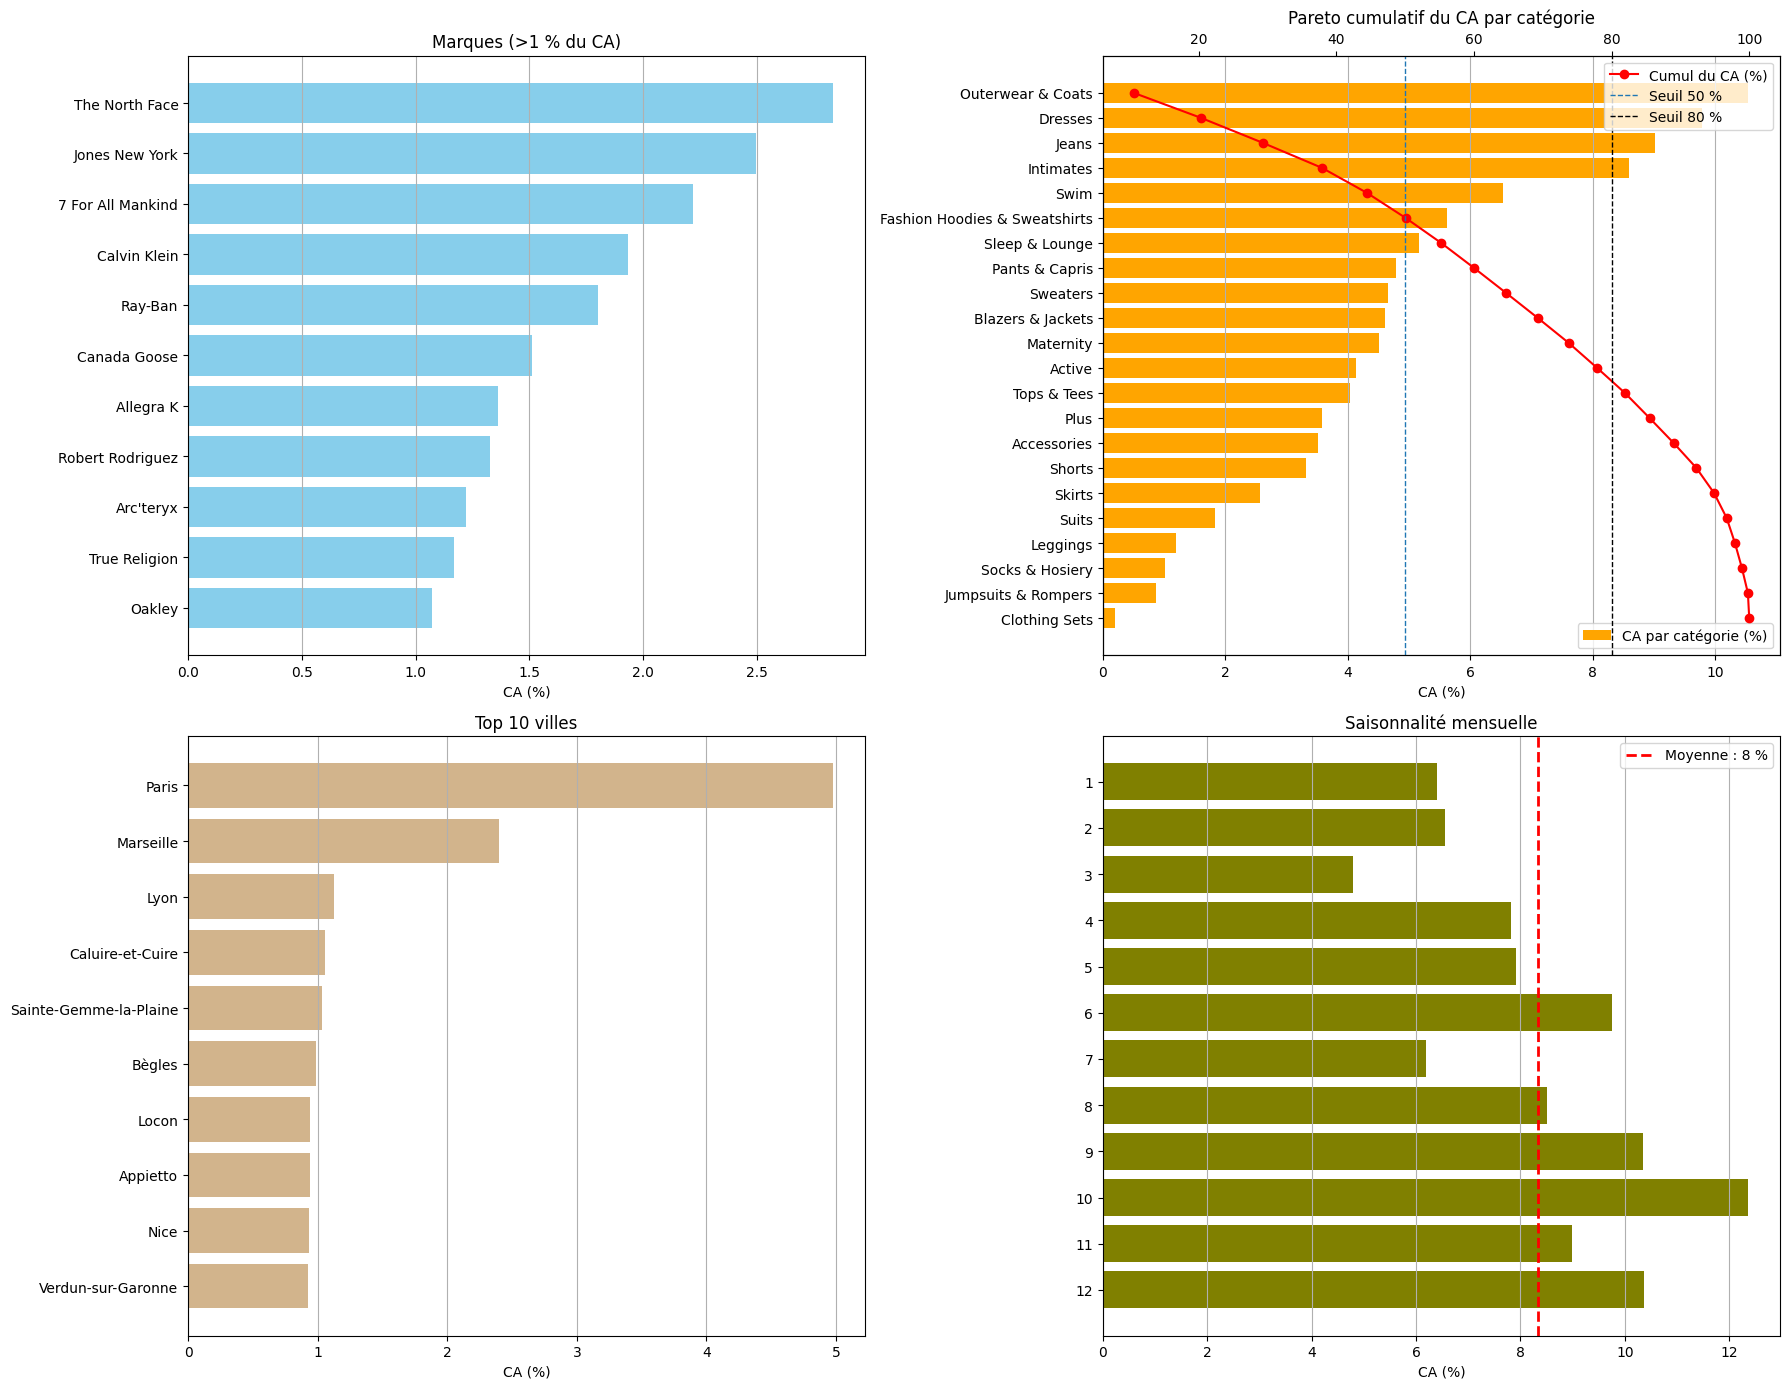

In [ ]:
# Données


# Total CA
total_ventes = df["sale_price"].sum()

# Marques (>1 % du CA)
marque_contrib = df.groupby("brand")["sale_price"].sum().sort_values(ascending=False)
marque_top = marque_contrib[marque_contrib / total_ventes > 0.01]
marque_top_pct = marque_top / total_ventes * 100  # CA en %

# Catégories (Pareto)
categorie_contrib = df.groupby("category", observed=True)["sale_price"].sum().sort_values(ascending=False)
categorie_df = categorie_contrib.reset_index()
categorie_df["pct"] = categorie_df["sale_price"] / total_ventes * 100  # CA en %
categorie_df["cumul_pct"] = categorie_df["pct"].cumsum()  # cumul en %

# Villes (top 10)
ville_contrib = df.groupby("city")["sale_price"].sum().sort_values(ascending=False)
ville_top = ville_contrib.head(10)
ville_top_pct = ville_top / total_ventes * 100  # CA en %

# Saisonnalité mensuelle
df["order_created_at"] = pd.to_datetime(df["order_created_at"])
df["month"] = df["order_created_at"].dt.month
month_contrib = df.groupby("month")["sale_price"].sum().sort_index()
month_pct = month_contrib / total_ventes * 100
moyenne_mensuelle_pct = month_pct.mean()


# Création des subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Marques (>1 %)
axes[0, 0].barh(marque_top_pct.index, marque_top_pct.values, color="skyblue")
axes[0, 0].invert_yaxis()
axes[0, 0].grid(visible=True, which='major', axis='x')
axes[0, 0].set_title("Marques (>1 % du CA)")
axes[0, 0].set_xlabel("CA (%)")

# Catégories : Pareto horizontal
ax_bar = axes[0, 1]
ax_line = ax_bar.twiny()
ax_bar.grid(visible=True, which='major', axis='x')

# Barres en %
ax_bar.barh(categorie_df["category"], categorie_df["pct"], color="orange", label="CA par catégorie (%)")

# Ligne cumulative en %
ax_line.plot(categorie_df["cumul_pct"], categorie_df["category"], marker="o", color="red", label="Cumul du CA (%)")

# Lignes seuils 50 % et 80 %
ax_line.axvline(50, linestyle="--", linewidth=1, label="Seuil 50 %")
ax_line.axvline(80, linestyle="--", linewidth=1, label="Seuil 80 %", color="black")

ax_bar.invert_yaxis()
ax_bar.set_title("Pareto cumulatif du CA par catégorie")
ax_bar.set_xlabel("CA (%)")

ax_bar.legend(loc="lower right")
ax_line.legend(loc="upper right")

# Villes (top 10)
axes[1, 0].barh(ville_top_pct.index, ville_top_pct.values, color="tan")
axes[1, 0].invert_yaxis()
axes[1, 0].grid(visible=True, which='major', axis='x')
axes[1, 0].set_title("Top 10 villes")
axes[1, 0].set_xlabel("CA (%)")

# Saisonnalité mensuelle
axes[1, 1].barh(month_pct.index.astype(str), month_pct.values, color="olive")
axes[1, 1].invert_yaxis()
axes[1, 1].grid(visible=True, which='major', axis='x')
axes[1, 1].set_title("Saisonnalité mensuelle")
axes[1, 1].set_xlabel("CA (%)")

# Ligne de moyenne mensuelle en %
axes[1, 1].axvline(
    moyenne_mensuelle_pct,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Moyenne : {int(round(moyenne_mensuelle_pct))} %"
)
axes[1, 1].legend(loc="upper right")

plt.tight_layout()
plt.show()


Afin de conserver une visualisation lisible, seules les marques représentant plus de 1 % du chiffre d’affaire total sont affichées. Ce seuil, bien que conventionnel, permet d’identifier les marques structurantes tout en évitant une surcharge visuelle.

Concernant la contribution par catégorie, on peut afficher l'ensemble de ces dernières car bien moins nombreuses que les marques. On constaste alors que seulement 6 d'entre elles (manteaux, robes, jeans, lingerie, maillots de bain, hoodie) font 50% du CA total et les 16 autres le reste.

Les commandes sont passées dans plus de 500 villes différentes. Pour des raisons d'affichage, seules les 10 premières sont affichées.
Sans surprise, on retrouve Paris en tête suivi de Marseille et Lyon.

Enfin, la saisonnalité mensuelle moyenne sur les deux années indiquent une certaine hétérogénéité entre les mois. On voit clairement que ce sont les derniers mois de l'année qui sont ceux qui rapportent le plus d'argent.

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_22684\3672679506.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("city")["sale_price"]


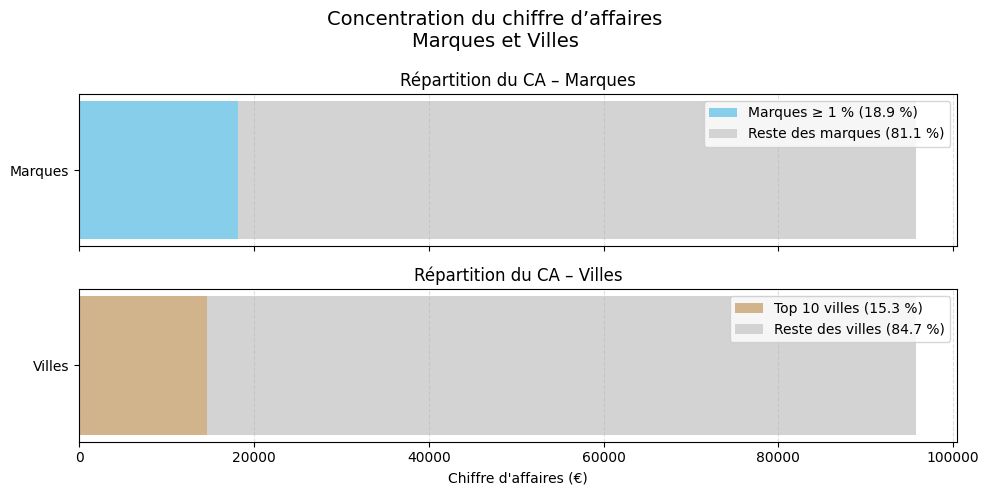

In [ ]:
# 1. Marques (> 1 % du CA)
ca_par_marque = (
    df.dropna(subset=["brand"])
      .groupby("brand")["sale_price"]
      .sum()
)

ca_total = ca_par_marque.sum()
seuil = 0.01 * ca_total

ca_marques_top = ca_par_marque[ca_par_marque >= seuil].sum()
ca_marques_reste = ca_par_marque[ca_par_marque < seuil].sum()

pct_marques_top = ca_marques_top / ca_total * 100
pct_marques_reste = ca_marques_reste / ca_total * 100



# 2. Villes (Top 10)
ca_par_ville = (
    df.groupby("city")["sale_price"]
      .sum()
      .sort_values(ascending=False)
)

ca_villes_top10 = ca_par_ville.head(10).sum()
ca_villes_reste = ca_par_ville.iloc[10:].sum()

pct_villes_top10 = ca_villes_top10 / ca_total * 100
pct_villes_reste = ca_villes_reste / ca_total * 100



# 3. Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Marques
axes[0].barh(
    ["Marques"],
    ca_marques_top,
    color="skyblue",
    label=f"Marques ≥ 1 % ({pct_marques_top:.1f} %)"
)

axes[0].barh(
    ["Marques"],
    ca_marques_reste,
    left=ca_marques_top,
    color="lightgrey",
    label=f"Reste des marques ({pct_marques_reste:.1f} %)"
)

axes[0].set_title("Répartition du CA – Marques")
axes[0].legend()
axes[0].grid(axis="x", linestyle="--", alpha=0.4)


# Villes
axes[1].barh(
    ["Villes"],
    ca_villes_top10,
    color="tan",
    label=f"Top 10 villes ({pct_villes_top10:.1f} %)"
)

axes[1].barh(
    ["Villes"],
    ca_villes_reste,
    left=ca_villes_top10,
    color="lightgrey",
    label=f"Reste des villes ({pct_villes_reste:.1f} %)"
)

axes[1].set_title("Répartition du CA – Villes")
axes[1].legend()
axes[1].grid(axis="x", linestyle="--", alpha=0.4)

axes[1].set_xlabel("Chiffre d'affaires (€)")

plt.suptitle("Concentration du chiffre d’affaires\nMarques et Villes", fontsize=14)
plt.tight_layout()
plt.show()



Les variables `brand` et `city` présentent une forte cardinalité (plus de 600 marques et 500 villes), rendant toute représentation exhaustive illisible.
Nous avons donc choisi d’analyser leur contribution au chiffre d’affaires à travers des visualisations synthétiques, mettant en évidence les phénomènes de concentration économique (marques contribuant à plus de 1 % du CA, villes concentrant 50 % du CA).
Cette approche permet de conserver l’information essentielle tout en assurant une lecture claire et interprétable des résultats.

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_22684\1625536544.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = df.groupby('state').size().reset_index(name='commandes')


                     state  commandes
0     Auvergne-Rhône-Alpes        243
1  Bourgogne-Franche-Comté         20
2                 Bretagne         81
3      Centre-Val de Loire         65
4                    Corse          2
Index(['code', 'nom', 'geometry'], dtype='object')


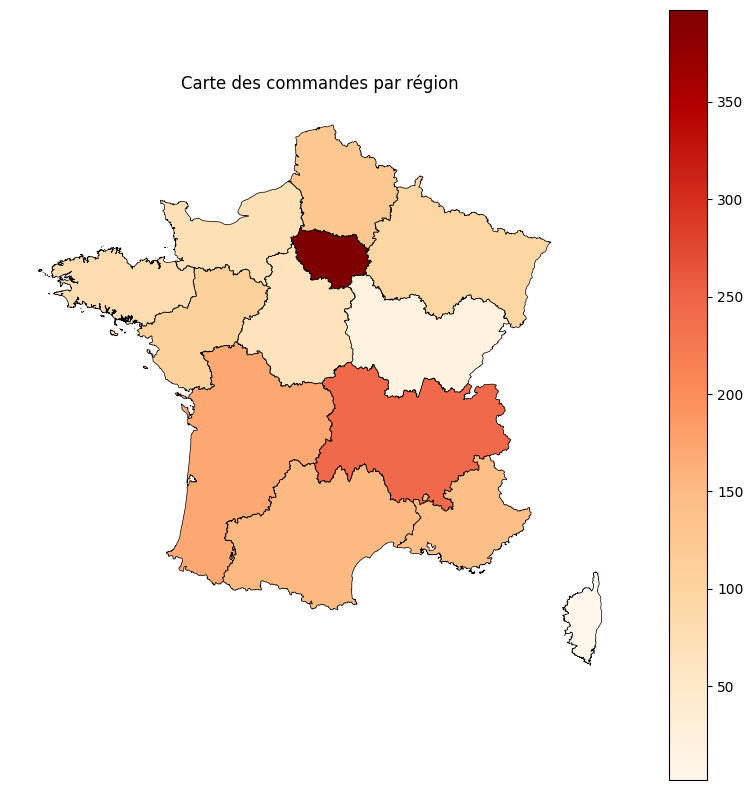

In [38]:
import geopandas as gpd


# --- Étape 1 : compter les commandes par région (state) ---
df_counts = df.groupby('state').size().reset_index(name='commandes')
print(df_counts.head())

# --- Étape 2 : charger le GeoJSON des régions françaises ---
url_geojson = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/regions.geojson"
regions = gpd.read_file(url_geojson)

# Vérifier les colonnes disponibles dans le GeoJSON
print(regions.columns)
# 'nom' = nom de la région

# --- Étape 3 : fusionner les données ---
df_geo = regions.merge(df_counts, left_on='nom', right_on='state', how='left')
df_geo['commandes'] = df_geo['commandes'].fillna(0)

# --- Étape 4 : tracer la carte ---
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_geo.plot(
    column='commandes',
    ax=ax,
    legend=True,
    cmap='OrRd',
    edgecolor='black',
    linewidth=0.5
)
ax.set_title("Carte des commandes par région")
ax.axis('off')

plt.show()